In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp 
from scipy.optimize import curve_fit
from FVMtools import FVMdisc2nd, FVMdiscBV, FVMdisc1st, FVMjpattern
import time 

In [2]:
df = pd.read_excel('Project2B_appendix.xlsx', sheet_name='grad')

#Select column called V1

V1, Cs1, UV1 = df['V1'].to_numpy(), df['Cs1'].to_numpy(), df['UV1'].to_numpy()
V2, Cs2, UV2 = df['V2'].to_numpy(), df['Cs2'].to_numpy(), df['UV2'].to_numpy()
V3, Cs3, UV3 = df['V3'].to_numpy(), df['Cs3'].to_numpy(), df['UV3'].to_numpy()
V4, Cs4, UV4 = df['V4'].to_numpy(), df['Cs4'].to_numpy(), df['UV4'].to_numpy()
V5, Cs5, UV5 = df['V5'].to_numpy(), df['Cs5'].to_numpy(), df['UV5'].to_numpy()
V6, Cs6, UV6 = df['V6'].to_numpy(), df['Cs6'].to_numpy(), df['UV6'].to_numpy()

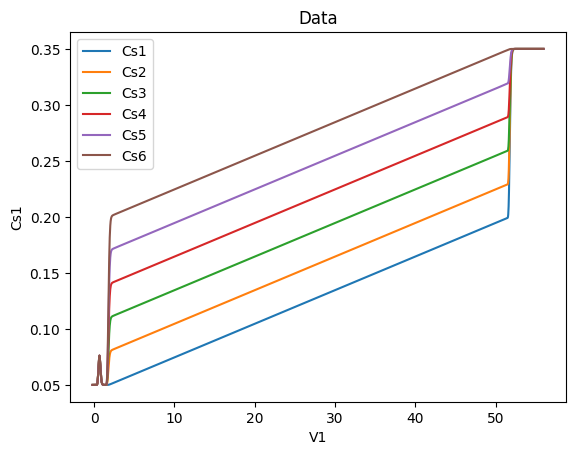

In [3]:
fig, ax = plt.subplots()

for i in range(1,7):
    ax.plot(df['V{}'.format(i)], df['Cs{}'.format(i)], label='Cs{}'.format(i))
    #ax.plot(df['V{}'.format(i)], df['UV{}'.format(i)], label='UV{}'.format(i))
ax.set_xlabel('V1')
ax.set_ylabel('Cs1')
ax.set_title('Data')
ax.legend()

plt.show()

In [4]:
beta = [8.41, 8.41, 4.57]
betaA = beta[0]
betaBC = beta[1]
betaD = beta[2]

qmax = 200 # for A, B and C

F = 5 #CV/h


In [5]:


M = 58.44
TotPep = 5/1
cAin = 0.169*TotPep
cBCin = 0.662*TotPep
cDin = 0.169*TotPep

SF = 0.10
SA = 0.05
SB = 0.35

ec = 0.42 
ep = 0.62 
L = 10e-2 #m

v = L #m/CV

Pe = 0.5 
Dp = 90e-6

# relations 
ee = ec + (1-ec)*ep 

Dax = (v*Dp)/Pe

N = 40

h = L/N


# discr 
[A2,A2f] = FVMdisc2nd(N, h, '3pc') 
[A1,A1f] = FVMdisc1st(N, h, '2pb') 
[B1,B0] = FVMdiscBV(N, h, [0, 1], [[1, -1],[0, 0]]) 

Ss = []
ts = []


In [6]:
def adsmodel(t, cq, H0A, H0BC, H0D, kin_A, kin_BC, kin_C): 
    N  =  int(len(cq)/6) 
    cA = cq[:N]
    cBC = cq[N:2*N]
    cD = cq[2*N:3*N]
    qA = cq[3*N:4*N]
    qBC = cq[4*N:5*N]
    qD = cq[5*N:6*N]
    
    if t<0:
        cinA = cAin
        cinBC = cBCin
        cinD = cDin
    else:
        cinA = 0
        cinBC = 0
        cinD = 0
    
    if t<0 : #Load
        S = SF 
    elif t<1: #Wash
        S = SA
    elif t<51 : #Elution
        Bstart = 0.1
        Bx = 0.01*(t-1) + Bstart
        S = Bx*SB+(1-Bx)*SA
    else: #Regeneration
        S = SB
        
    Ss.append(S)
    ts.append(t)
    HA = H0A*S**-betaA
    HBC = H0BC*S**-betaBC
    HD = H0D*S**-betaD
    
    qtot = qA+qBC+qD
    
    # adsorption 
    radsA = kin_A*(HA*cA*(1-(1/qmax)*qtot))-qA
    radsBC = kin_BC*(HBC*cBC*(1-(1/qmax)*qtot))-qBC
    radsD = kin_C*(HD*cD*(1-(1/qmax)*qtot))-qD
 
 
    # assembly 
    dcAdt = Dax*(A2@cA + A2f@(B1@cA + B0*cinA)) - v/ee*(A1@cA + A1f@(B1@cA + B0*cinA)) - (1-ec)/ec*radsA
    dcBCdt = Dax*(A2@cBC + A2f@(B1@cBC + B0*cinBC)) - v/ee*(A1@cBC + A1f@(B1@cBC + B0*cinBC)) - (1-ec)/ec*radsBC
    dcDdt = Dax*(A2@cD + A2f@(B1@cD + B0*cinD)) - v/ee*(A1@cD + A1f@(B1@cD + B0*cinD)) - (1-ec)/ec*radsD
   
    dcdt = np.hstack((dcAdt, dcBCdt, dcDdt))
    
    dqAdt = radsA
    dqBCdt = radsBC
    dqDdt = radsD
    
    dqdt = np.hstack((dqAdt, dqBCdt, dqDdt))
    
    dcqdt = np.hstack((dcdt, dqdt)) 
    return dcqdt 

def adssim(t, H0A, H0BC, H0D, kin_A, kin_BC, kin_C):
    tspan = [t[0],56]
    cqinit = np.hstack((0*np.ones(N),0*np.ones(N),0*np.ones(N), 0*np.ones(N), 0*np.ones(N), 0*np.ones(N) ))
    JP = FVMjpattern(lambda t, cq: adsmodel(t, cq, H0A, H0BC, H0D, kin_A, kin_BC, kin_C),len(cqinit))
    sol = solve_ivp(lambda t, cq: adsmodel(t, cq, H0A, H0BC, H0D, kin_A, kin_BC, kin_C), tspan, cqinit, method='BDF', t_eval=t,jac_sparsity=JP)
    t = sol.t
    cA = sol.y[N-1,:] 
    cBC = sol.y[2*N-1,:]
    cD = sol.y[3*N-1,:]
    
    return t, cA, cBC, cD

def fitting_func_H(t, H0A, H0BC, H0D, kin_A, kin_BC, kin_C):
    _, cA, cBC, cD = adssim(t, H0A, H0BC, H0D, kin_A, kin_BC, kin_C)
    CUV = cA + cBC + cD
    return CUV

def fitting_func_kin(t, kin_A, kin_BC, kin_C, H0A, H0BC, H0D):
    _, cA, cBC, cD = adssim(t, H0A, H0BC, H0D, kin_A, kin_BC, kin_C)
    CUV = cA + cBC + cD
    return CUV

In [7]:
H0 = [1.2e-5, 3.6e-6, 3.0e-4]


H0A = H0[0]
H0BC = H0[1]*0.8
H0D = H0[2]*0.3


kkin = np.array([15, 18, 43.4])/F
kkinA = kkin[0]*0.8
kkinBC = kkin[1]
kkinD = kkin[2]
fittingH = lambda t, H0A, H0BC, H0D: fitting_func_H(t, H0A, H0BC, H0D, kkinA, kkinBC, kkinD)
fittingKin = lambda t, kkinA, kkinBC, kkinD: fitting_func_kin(t, kkinA, kkinBC, kkinD, H0A, H0BC, H0D)
fittingAll = lambda t, H0A, H0BC, H0D, kkinA, kkinBC, kkinD: fitting_func_H(t, H0A, H0BC, H0D, kkinA, kkinBC, kkinD)

#popt_H, pcov_H = curve_fit(fittingH, V1, UV1, p0=[H0A, H0BC, H0D], epsfcn=1e-5)
#popt_kin, pcov_kin = curve_fit(fittingKin, V2, UV2, p0=[kkinA, kkinBC, kkinD], epsfcn=1e-5)

popt, pcov = curve_fit(fittingAll,  V1, UV1, p0=[H0A, H0BC, H0D, kkinA, kkinBC, kkinD], epsfcn=1e-5)

In [ ]:
#print(f"Optimized H values: {popt_H}")
#print(f"Optimized kin values: {popt_kin}")

print(f"kkina: {kkinA}, kkinc: {kkinBC}, kkind: {kkinD}")
print(f"H0A: {H0A}, H0BC: {H0BC}, H0D: {H0D}")

kkina: 2.4000000000000004, kkinc: 3.6, kkind: 8.68
H0A: 1.2e-05, H0BC: 2.88e-06, H0D: 8.999999999999999e-05


In [ ]:
#t, cA_opt_H, cBC_opt_H, cD_opt_H = adssim(V1, *popt_H, kkinA, kkinBC, kkinD)
#t, cA_opt_kin, cBC_opt_kin, cD_opt_kin = adssim(V1, H0A, H0BC, H0D, *popt_kin)
t, cA, cBC, cD = adssim(V1, H0A, H0BC, H0D, kkinA, kkinBC, kkinD)
#t, cA_opt, cBC_opt, cD_opt = adssim(V1, *popt_H, *popt_kin)
t, cA_opt2, cBC_opt2, cD_opt2 = adssim(V1, *popt)

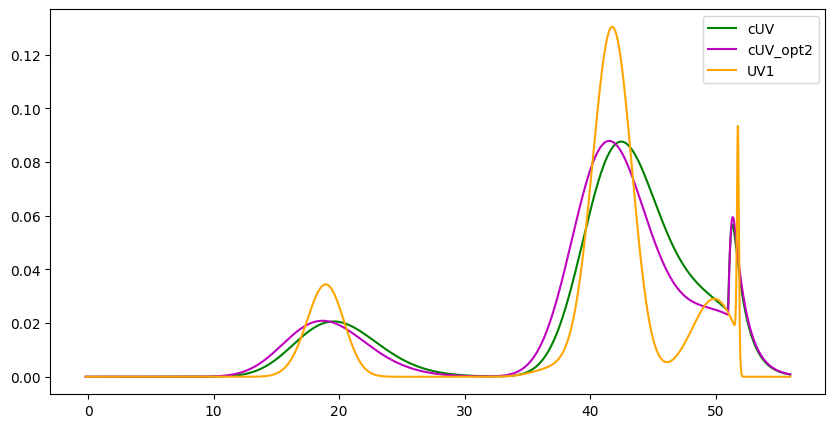

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
#ax.plot(t, cA_opt_H+cBC_opt_H+cD_opt_H, label='cUV_opt_H', color='red')
#ax.plot(t, cA_opt_kin+cBC_opt_kin+cD_opt_kin, label='cUV_opt_kin', color='blue')
ax.plot(t, cA+cBC+cD, label='cUV', color='green')
#ax.plot(t, cA_opt+cBC_opt+cD_opt, label='cUV_opt', color='black')
ax.plot(t, cA_opt2+cBC_opt2+cD_opt2, label='cUV_opt2', color='m')
ax.plot(V1, UV1, label='UV1', color='orange')
ax.legend()

#Green = Blue
#Black = Red

#Save figure
plt.savefig(f'opt1614.png', dpi=300)